In [17]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [18]:
data

,sent_id,text,label
5060,700798-02-01,american honey skitten betagende film rotløs u...,1
2115,003576-15-01,glad dyr ta turen festen fortelling,1
4794,304825-04-01,pixar kvier aldri sette kluter følelsesmessige...,1
873,102785-04-03,biograf lars ericson wolke argumenterer overbe...,1
4077,103992-13-01,serien hviler heller lenger enkeltkarakterer,1
...,...,...,...
4467,601408-03-03,kjent oliver h langeland fikk bok dømmes inndr...,0
1600,102359-09-06,bryr nevneverdig alt,0
3755,702152-11-02,sluttbudskap overflatisk selvfølgelig latterlig,0
1729,109725-02-01,ludderrock,0


In [19]:
from collections import Counter

num_words = Counter()
for review in data["text"]:
    for word in review.split(" "):
        num_words[word] += 1

num_words = len(num_words)
print("Number of words:", num_words)

Number of words: 12209


<AxesSubplot:>

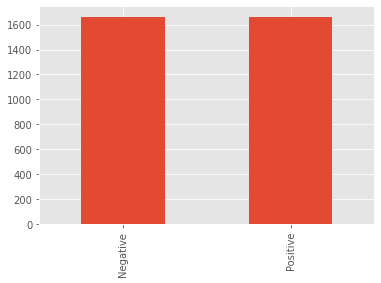

In [20]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

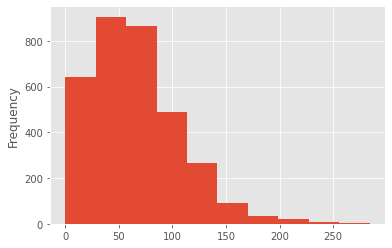

In [21]:
data["text"].str.len().plot.hist()

In [22]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(data["text"])
sequences = tokenizer.texts_to_sequences(data["text"])

word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

padded_data = pad_sequences(sequences, maxlen=100)

Found 12208 unique tokens.


In [23]:
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

encoder = LabelEncoder()
labels = encoder.fit_transform(data["label"])
labels = to_categorical(labels)

X_train, X_val, y_train, y_val = train_test_split(padded_data, labels, test_size=0.2, random_state=42, shuffle=True)

In [24]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2660, 100) (2660, 2)
(666, 100) (666, 2)


In [25]:
from backend.src.utils.embeddings import load_embeddings

embeddings_index = load_embeddings()

Loading embeddings: 100%|██████████| 4031461/4031461 [03:16<00:00, 20525.21it/s]


In [27]:
import numpy as np

vocab_size = len(word_index) + 1
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [28]:
from keras import Input
from keras.layers import Embedding, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Input(shape=(embedding_dim,), dtype="float32"))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(2, activation="softmax"))

In [29]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1220900   
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 100)               1000100   
                                                                 
 dense_4 (Dense)             (None, 32)                3232      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2,224,298
Trainable params: 1,003,398
No

In [30]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 50
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=1,
                    callbacks=[early_stop])

Epoch 1/50
84/84 [==============================] - 2s 18ms/step - loss: 0.6771 - accuracy: 0.5782 - val_loss: 0.6586 - val_accuracy: 0.6081
Epoch 2/50
84/84 [==============================] - 1s 13ms/step - loss: 0.5181 - accuracy: 0.7429 - val_loss: 0.7100 - val_accuracy: 0.5841
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.3969 - accuracy: 0.8229 - val_loss: 0.8059 - val_accuracy: 0.6141
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.2576 - accuracy: 0.8989 - val_loss: 1.0061 - val_accuracy: 0.5841
Epoch 5/50
84/84 [==============================] - 1s 15ms/step - loss: 0.1472 - accuracy: 0.9534 - val_loss: 1.2909 - val_accuracy: 0.5916
Epoch 6/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0740 - accuracy: 0.9797 - val_loss: 1.5379 - val_accuracy: 0.5931


In [31]:
from datetime import datetime

model.save(f"models/SA-GLOVE-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

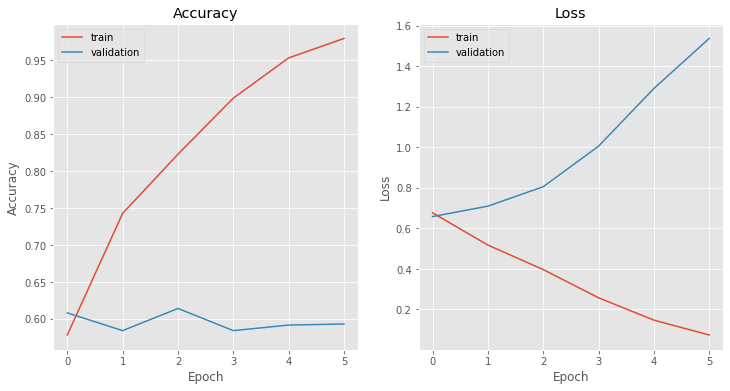

In [32]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [33]:
# Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

21/21 [==============================] - 0s 4ms/step - loss: 1.5379 - accuracy: 0.5931
Validation loss: 1.5378650426864624
Validation accuracy: 0.5930930972099304
